In [1]:
import pandas as pd
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from collections import Counter

def load_dataset(filepath):
    df = pd.read_csv(filepath, delimiter='\t', header=None, usecols=[1, 2], names=['label', 'statement'])
    df['label'] = df['label'].apply(lambda x: 1 if x in ['false', 'barely-true', 'pants-fire','half-true'] else 0)
    return df

train_df = load_dataset('/kaggle/input/liar-dataset/train.tsv')
test_df = load_dataset('/kaggle/input/liar-dataset/test.tsv')
valid_df = load_dataset('/kaggle/input/liar-dataset/valid.tsv')

train_sentences = train_df['statement'].values
train_labels = train_df['label'].values

test_sentences = test_df['statement'].values
test_labels = test_df['label'].values

valid_sentences = valid_df['statement'].values
valid_labels = valid_df['label'].values

In [2]:
test_df

,label,statement
0,0,Building a wall on the U.S.-Mexico border will...
1,1,Wisconsin is on pace to double the number of l...
2,1,Says John McCain has done nothing to help the ...
3,1,Suzanne Bonamici supports a plan that will cut...
4,1,When asked by a reporter whether hes at the ce...
...,...,...
1262,1,Says his budget provides the highest state fun...
1263,1,Ive been here almost every day.
1264,1,"In the early 1980s, Sen. Edward Kennedy secret..."
1265,1,Says an EPA permit languished under Strickland...


# Simple Tokenization

In [3]:
# Tokenization
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# Build vocab
vocab = build_vocab_from_iterator(yield_tokens(train_sentences), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Encode text and labels
def text_pipeline(x):
    return vocab(tokenizer(x))

def label_pipeline(x):
    return int(x)

# Create a custom dataset
class NewsDataset(Dataset):
    def __init__(self, sentences, labels, text_pipeline, label_pipeline):
        self.sentences = sentences
        self.labels = labels
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        text = self.text_pipeline(self.sentences.iloc[idx])
        label = self.label_pipeline(self.labels.iloc[idx])
        return torch.tensor(text, dtype=torch.int64).clone().detach(), torch.tensor(label, dtype=torch.int64)
    

from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    text_list, label_list = [], []
    for (_text, _label) in batch:
        processed_text = _text
        text_list.append(processed_text)
        label_list.append(_label)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)  # Pad your sequences here
    label_list = torch.stack(label_list)
    return text_list, label_list

# Create datasets
train_dataset = NewsDataset(train_df['statement'], train_df['label'], text_pipeline, label_pipeline)
test_dataset = NewsDataset(test_df['statement'], test_df['label'], text_pipeline, label_pipeline)
valid_dataset = NewsDataset(valid_df['statement'], valid_df['label'], text_pipeline, label_pipeline)

# Create data loaders
batch_size = 4 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)



In [16]:
torch.cuda.is_available()

True

In [13]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'  
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: fake or real

# Tokenize sentences and convert labels to tensors
train_encodings = tokenizer(train_sentences.tolist(), truncation=True, padding=True, return_tensors='pt')
train_labels_tensor = torch.tensor(train_labels)

valid_encodings = tokenizer(valid_sentences.tolist(), truncation=True, padding=True, return_tensors='pt')
valid_labels_tensor = torch.tensor(valid_labels)

test_encodings = tokenizer(test_sentences.tolist(), truncation=True, padding=True, return_tensors='pt')
test_labels_tensor = torch.tensor(test_labels)

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = CustomDataset(train_encodings, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

valid_dataset = CustomDataset(valid_encodings, valid_labels_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

test_dataset = CustomDataset(test_encodings, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Fine-tuning the BERT model
optimizer = torch.optim.Adam(bert_model.parameters(), lr=5e-4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
bert_model.to(device)

num_epochs = 5
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
valid_accuracies = []
valid_losses = []
for epoch in range(num_epochs):
    bert_model.train()
    total_loss = 0
    correct_count = 0
    total_count = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}', leave=False):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        correct_count += (predictions == labels).sum().item()
        total_count += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_count / total_count
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Evaluate on validation set
    bert_model.eval()
    valid_correct_count = 0
    valid_total_count = 0
    valid_loss = 0
    for batch in tqdm(valid_loader, desc='Validation', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        with torch.no_grad():
            outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        valid_loss += loss.item()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        valid_correct_count += (predictions == labels).sum().item()
        valid_total_count += labels.size(0)
    valid_accuracy = valid_correct_count / valid_total_count
    valid_accuracies.append(valid_accuracy)
    valid_losses.append(valid_loss / len(valid_loader))

    print(f'Epoch {epoch + 1}, Validation Accuracy: {valid_accuracy:.4f}')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 0/1280 [00:00<?, ?it/s]/tmp/ipykernel_34/498833494.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/498833494.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch 1, Train Loss: 0.6855, Train Accuracy: 0.6101


Epoch 1, Validation Accuracy: 0.6729


Epoch 2, Train Loss: 0.6864, Train Accuracy: 0.6087


Epoch 2, Validation Accuracy: 0.6729


Epoch 3, Train Loss: 0.6794, Train Accuracy: 0.6124


Epoch 3, Validation Accuracy: 0.6729


Epoch 4, Train Loss: 0.6845, Train Accuracy: 0.6116


Epoch 4, Validation Accuracy: 0.6729


Epoch 5, Train Loss: 0.6889, Train Accuracy: 0.6032


Epoch 5, Validation Accuracy: 0.6729


In [14]:
 # Evaluate on test set
test_loss = 0
test_correct_count = 0
test_total_count = 0
for batch in tqdm(test_loader, desc='Testing', leave=False):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
    logits = outputs.logits
    loss = outputs.loss
    test_loss += loss.item()

    # Calculate accuracy
    predictions = torch.argmax(logits, dim=-1)
    test_correct_count += (predictions == labels).sum().item()
    test_total_count += labels.size(0)

test_loss /= len(test_loader)
test_accuracy = test_correct_count / test_total_count
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Print final test accuracy
final_test_accuracy = test_accuracies[-1]
print(f'Final Test Accuracy: {final_test_accuracy:.4f}')

Testing:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_34/498833494.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/498833494.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
                                                          

Test Loss: 0.6494, Test Accuracy: 0.6456
Final Test Accuracy: 0.6456


In [20]:
print(bert_model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

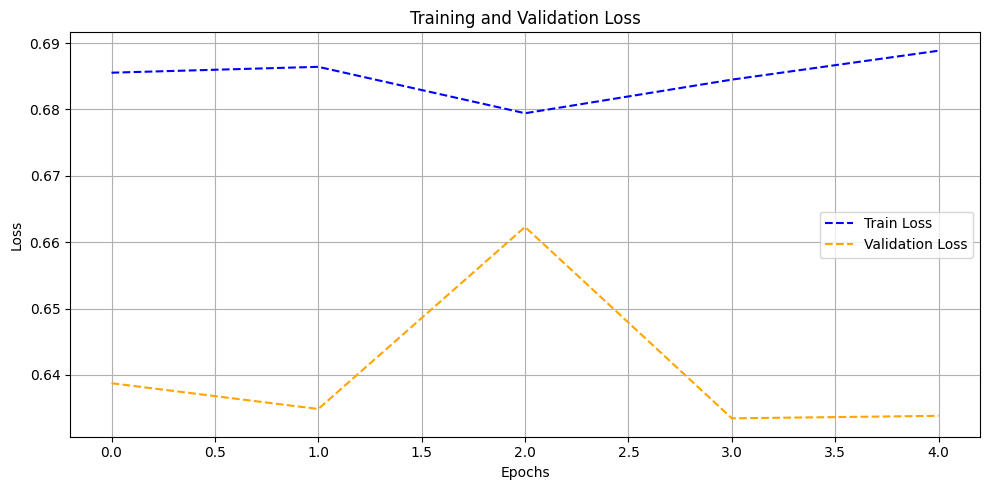

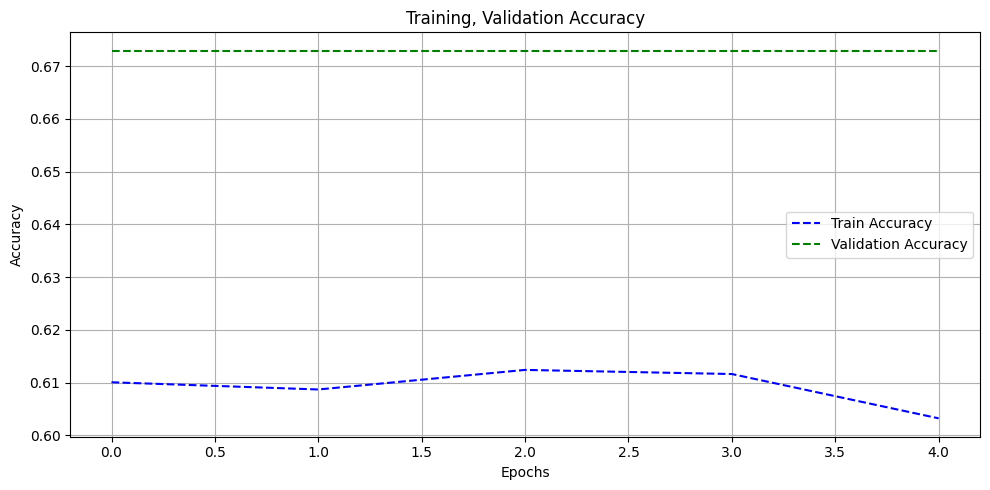

In [15]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='dashed', linewidth=1.5)
plt.plot(valid_losses, label='Validation Loss', color='orange', linestyle='dashed', linewidth=1.5)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='blue', linestyle='dashed', linewidth=1.5)
plt.plot(valid_accuracies, label='Validation Accuracy', color='green', linestyle='dashed', linewidth=1.5)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
import torch.nn as nn
from transformers import BertModel

class BertWithCNN(nn.Module):
    def __init__(self, num_classes):
        super(BertWithCNN, self).__init__()

        # Load pre-trained BERT model
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')

        # Freeze the parameters of the BERT model
        for param in self.bert_model.parameters():
            param.requires_grad = False

        # Define the CNN layers
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=50, kernel_size=20, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=1),
            nn.Conv1d(in_channels=50, out_channels=100, kernel_size=20, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=1)
        )

        # Final fully connected layer for classification
        self.fc = nn.Linear(100, num_classes)

    def forward(self, input_ids, attention_mask):
        # Pass the input through the BERT model
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        # CNN layers
        cnn_input = pooled_output.unsqueeze(-1).permute(0, 2, 1)  # Reshape for CNN input
        cnn_output = self.cnn_layers(cnn_input)
#         print(cnn_output.shape)
        cnn_output = nn.functional.max_pool1d(cnn_output, kernel_size=cnn_output.size(-1)).squeeze(-1)  # Global max pooling

        # Final classification layer
        logits = self.fc(cnn_output)

        return logits

num_classes = 2 
bert_with_cnn_model = BertWithCNN(num_classes)

print(bert_with_cnn_model)


BertWithCNN(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [58]:
# pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [41]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = Adam(bert_with_cnn_model.parameters(), lr=2e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_with_cnn_model.to(device)

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    bert_with_cnn_model.train()
    epoch_train_loss = 0.0
    correct_count = 0
    total_count = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        logits = bert_with_cnn_model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * len(labels)

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=-1)
        correct_count += (predictions == labels).sum().item()
        total_count += labels.size(0)
    
    epoch_train_loss /= len(train_dataset)
    train_losses.append(epoch_train_loss)
    train_accuracy = correct_count / total_count
    train_accuracies.append(train_accuracy)

    print(f'Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Evaluation on validation set
    bert_with_cnn_model.eval()
    epoch_valid_loss = 0.0
    valid_correct_count = 0
    valid_total_count = 0
    for batch in tqdm(valid_loader, desc='Validation', leave=False):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = bert_with_cnn_model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            epoch_valid_loss += loss.item() * len(labels)
            
            predictions = torch.argmax(logits, dim=-1)
            valid_correct_count += (predictions == labels).sum().item()
            valid_total_count += labels.size(0)
    
    epoch_valid_loss /= len(valid_dataset)
    valid_losses.append(epoch_valid_loss)
    valid_accuracy = valid_correct_count / valid_total_count
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch {epoch + 1}, Validation Loss: {epoch_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')

# Print final loss and accuracy
print(f'Final Train Loss: {train_losses[-1]:.4f}, Final Train Accuracy: {train_accuracies[-1]:.4f}')
print(f'Final Validation Loss: {valid_losses[-1]:.4f}, Final Validation Accuracy: {valid_accuracies[-1]:.4f}')


Epoch 1:   0%|          | 0/1280 [00:00<?, ?it/s]/tmp/ipykernel_34/498833494.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/498833494.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch 1, Train Loss: 0.6508, Train Accuracy: 0.6446


Epoch 1, Validation Loss: 0.6300, Validation Accuracy: 0.6729


Epoch 2, Train Loss: 0.6474, Train Accuracy: 0.6447


Epoch 2, Validation Loss: 0.6300, Validation Accuracy: 0.6729


Epoch 3, Train Loss: 0.6467, Train Accuracy: 0.6447


Epoch 3, Validation Loss: 0.6293, Validation Accuracy: 0.6729


Epoch 4, Train Loss: 0.6460, Train Accuracy: 0.6447


Epoch 4, Validation Loss: 0.6267, Validation Accuracy: 0.6729


Epoch 5, Train Loss: 0.6456, Train Accuracy: 0.6447


Epoch 5, Validation Loss: 0.6319, Validation Accuracy: 0.6729
Final Train Loss: 0.6456, Final Train Accuracy: 0.6447
Final Validation Loss: 0.6319, Final Validation Accuracy: 0.6729


In [53]:
test_dataset = CustomDataset(test_encodings, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [56]:
 # Evaluate on test set
test_loss = 0
test_correct_count = 0
test_total_count = 0
for batch in tqdm(test_loader, desc='Testing', leave=False):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        outputs = bert_with_cnn_model(input_ids, attention_mask=attention_mask)
    with torch.no_grad():
        # Forward pass
        logits = bert_with_cnn_model(input_ids, attention_mask)
    
    # Apply sigmoid activation
    predictions = (logits > 0.5).long()
    test_correct_count += (predictions == labels).sum().item()
    test_total_count += labels.size(0)

test_accuracy = test_correct_count / test_total_count
test_accuracies.append(test_accuracy)

# Print final test accuracy
final_test_accuracy = test_accuracies[-1]
print(f'Final Test Accuracy: {final_test_accuracy:.4f}')

Testing:   0%|          | 0/634 [00:00<?, ?it/s]/tmp/ipykernel_34/498833494.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/498833494.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
                                                          

Final Test Accuracy: 0.7088
